# Лабраторная работа 1

___

### ФИО: Владимиров Эдуард
### Группа: Б05-928

___

# План

### 1) [Подготовка данных к анализу](#preparation)
### 2) [Разведочный анализ данных](#analysis)
### 3) [Простроение и выбор моделей](#pipline)
### 4) [Итоговые результаты и выводы](#results)

In [39]:
import math
import scipy
import warnings
import math as m
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import scipy.stats as sps
from scipy.special import inv_boxcox

from statsmodels import tsa, graphics
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import statsmodels.api as sm

In [46]:
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

___

# Подготовка данных к анализу <a name="preparation"></a>

Загрузка данных, приведение к подходящему для работы виду.

In [3]:
def load_dataset(path):
    data = pd.read_csv(path, index_col=0)
    data['acc'] = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    return data

In [4]:
ts = load_dataset('../data/walk_accelerometer.csv')
ts.head()

,time,X_value,Y_value,Z_value,acc
0,9.9987,4.47490,-7.43422,-0.42379,8.687460
1,10.0010,4.63053,-7.32169,-0.41660,8.673091
2,10.0026,4.92742,-7.10860,-0.40463,8.658833
3,10.0048,5.19558,-6.91706,-0.41660,8.661023
4,10.0070,5.30811,-6.84763,-0.43815,8.675139


___
# Разведочный анализ данных <a name="analysis"></a>	

Все, что подходит для вашего временного ряда и вашей будущей модели.

* Проанализируйте на тренд, периодичность и шум (например, SSA);
* Проанализируйте автокорреляцию;
* ...

В примере, сегмент временного ряда и визуальная оценка применимости авторегрессионной модели по автокорреляции.

### Визуализация

**Отрисовка данных на всей временной оси**

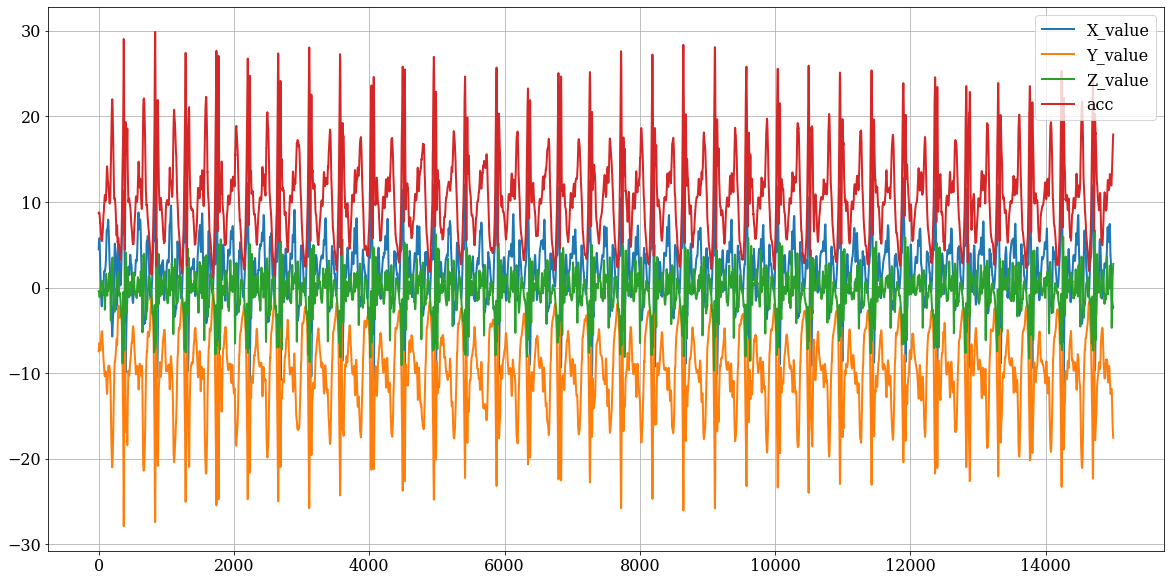

In [ ]:
_ = ts.iloc[:, pd.IndexSlice[1:5]].plot(figsize=(20, 10))
plt.grid(True)

**Отрисовка данных на двух периодах**

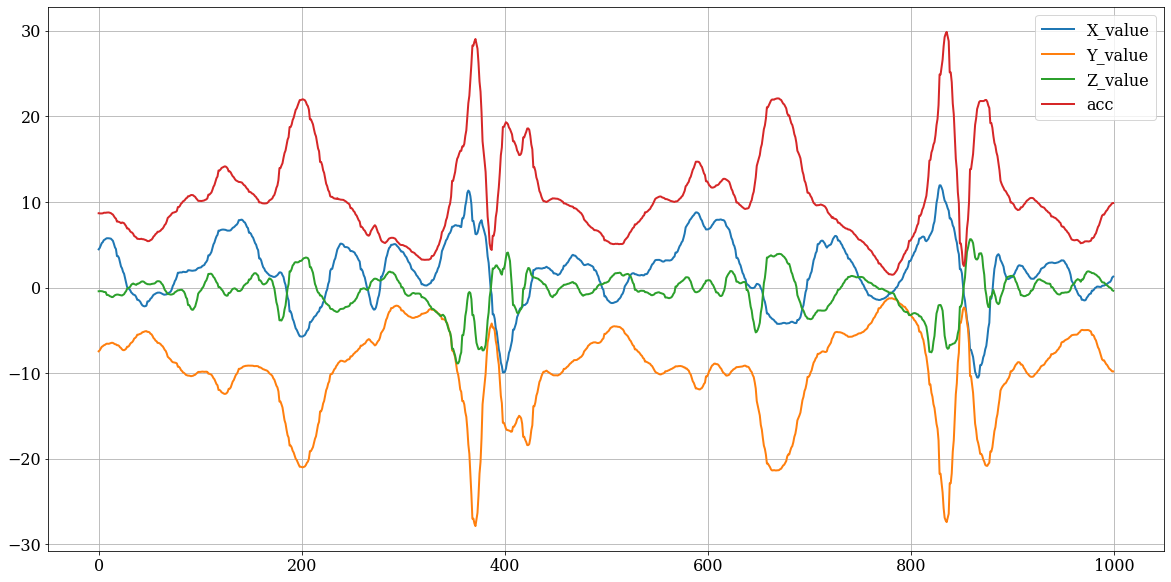

In [ ]:
_ = ts.iloc[:1000, pd.IndexSlice[1:5]].plot(figsize=(20, 10))
plt.grid(True)

### ACF и PACF

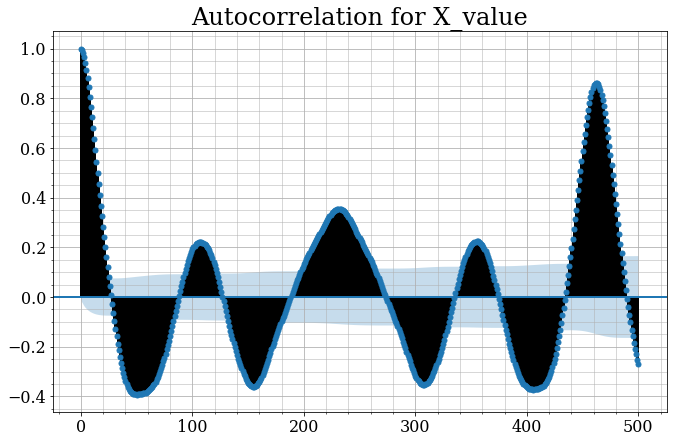

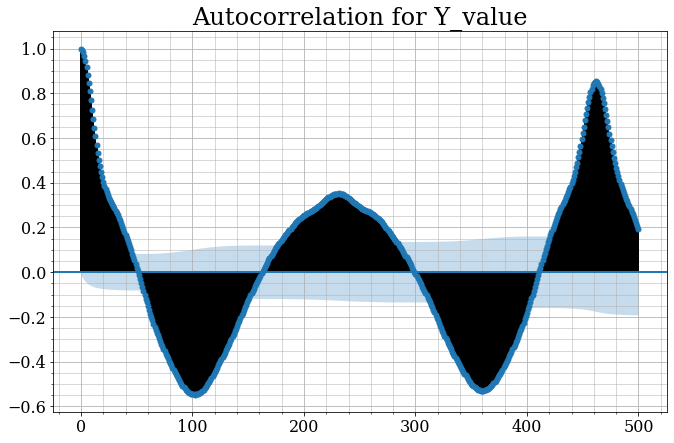

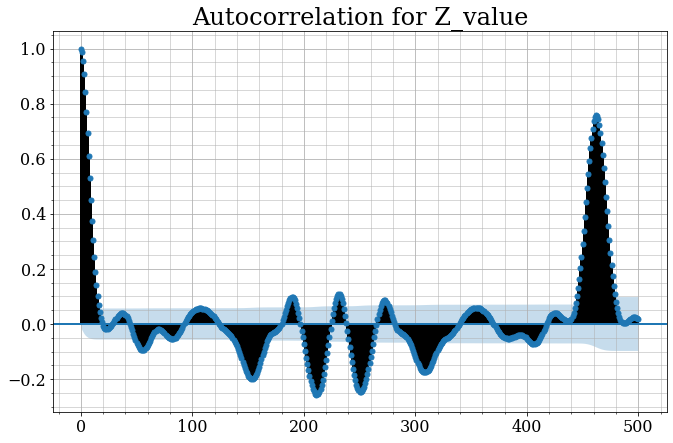

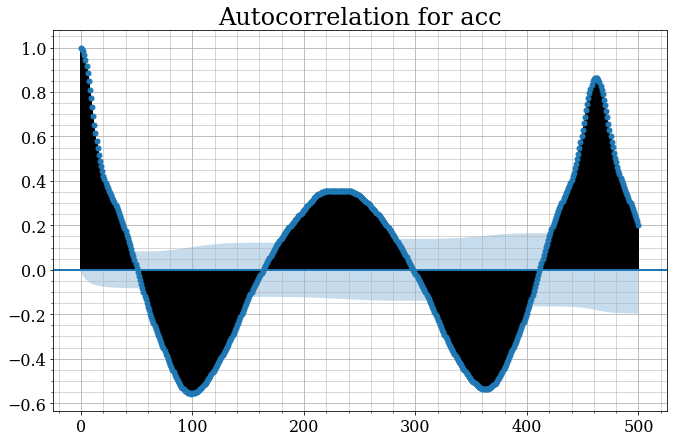

In [5]:
explored_columns = ts.columns[1:5]

for col in explored_columns:
    plot_acf(ts[col], lags=500, title = f'Autocorrelation for {col}')
    plt.grid(which='major', linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', linewidth = 0.5)

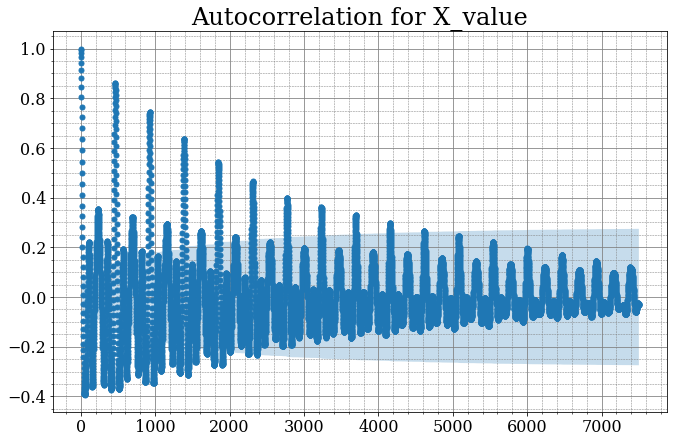

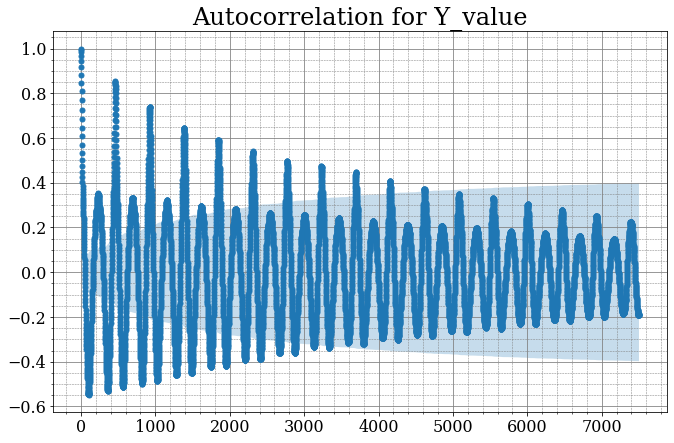

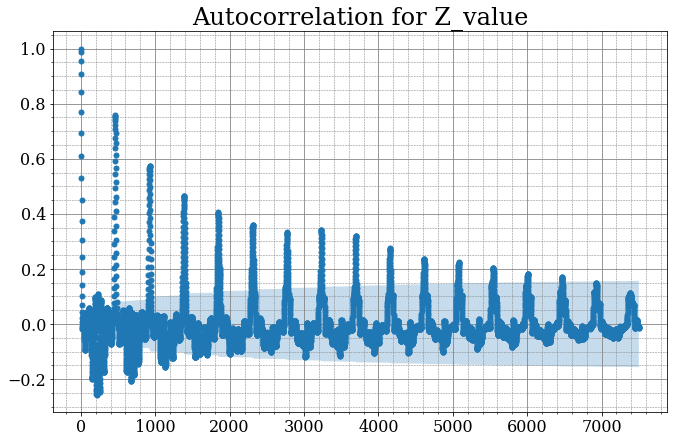

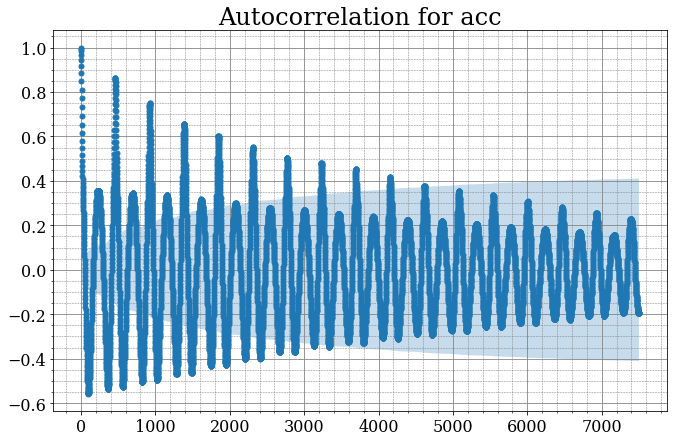

In [ ]:
for col in explored_columns:
    plot_acf(
        ts[col],
        lags = int(len(ts)/2),
        use_vlines = False,
        alpha=0.1
    ) 
    plt.tick_params(axis='both', which='major')
    plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', 
        color = 'gray', 
        linestyle = '--',
        linewidth = 0.5)
    plt.title(f'Autocorrelation for {col}')
    plt.show()

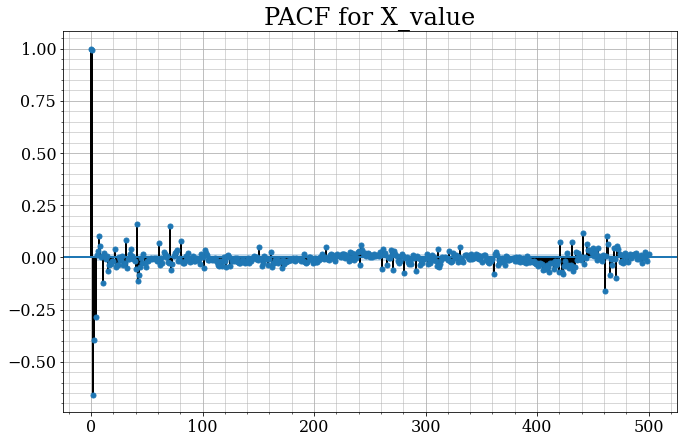

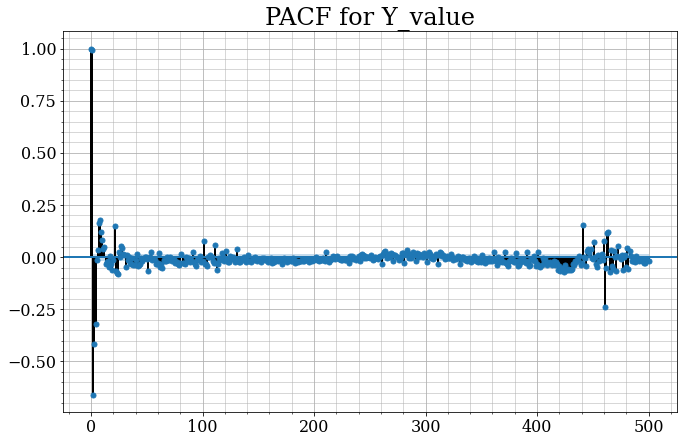

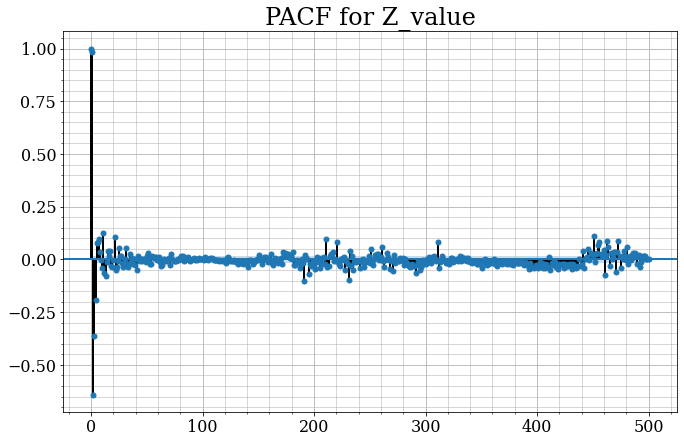

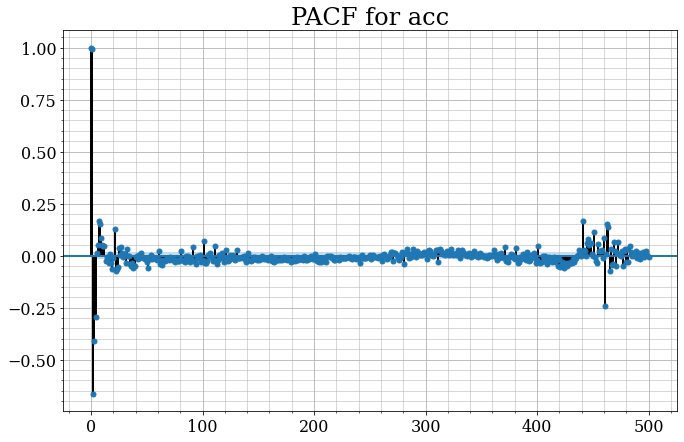

In [ ]:
for col in explored_columns:
    plot_pacf(ts[col], lags=500, title = f"PACF for {col}")
    plt.grid(which='major', linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', linewidth = 0.5)

In [11]:
PERIOD = 462

### Наличие выбросов

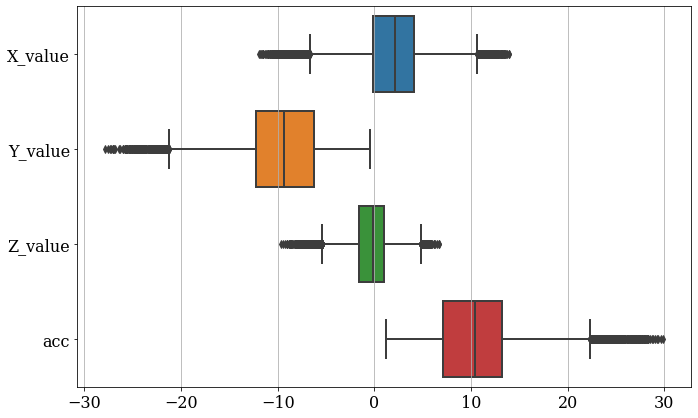

In [ ]:
plt.figure()
plt.grid(True)

sn.boxplot(data=ts.iloc[:, pd.IndexSlice[1:5]], orient='h', ax=plt.gca());

**Вывод:** Ввиду наличия выбросов применим преобразование Бокса-Кокса

In [9]:
boxcox_add_constants = np.array([15, 0, 12, 0])
boxcox_mult_constants = np.array([1, -1, 1, 1])
LAMBDA = 0

boxcox_ts = []

for i, col in enumerate(explored_columns):
    add_const = boxcox_add_constants[i]
    mult_const = boxcox_mult_constants[i]
    modified_ts = ts[col] * mult_const + add_const
    modified_ts = sps.boxcox(modified_ts, lmbda=LAMBDA)
    
    boxcox_ts.append(modified_ts)
    
boxcox_ts = pd.DataFrame(boxcox_ts).T
boxcox_ts.columns = explored_columns

**Визуализация полученных временных рядов**

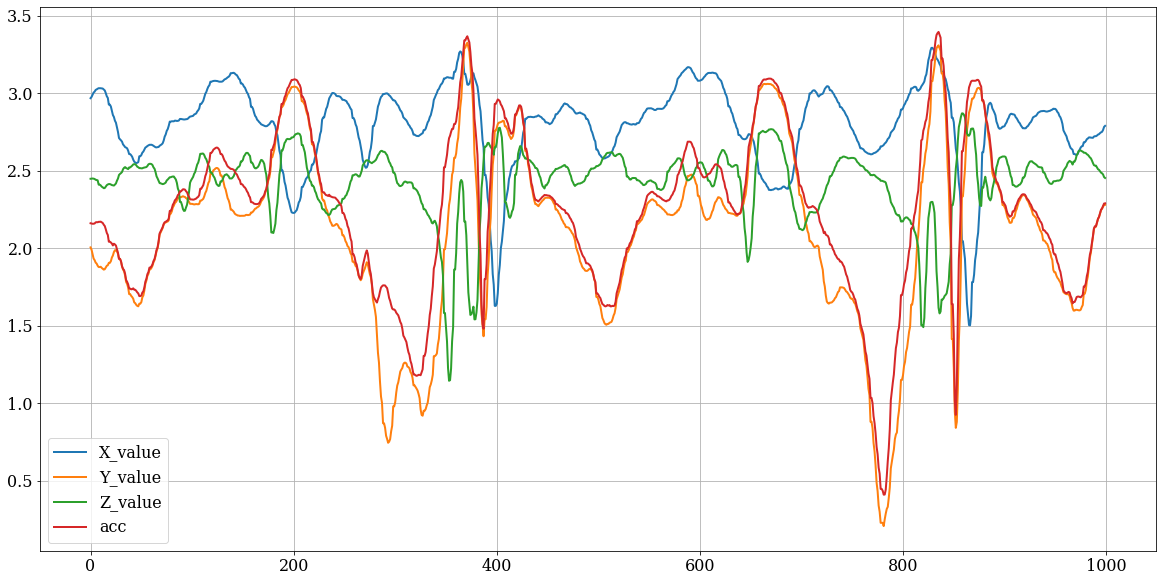

In [ ]:
_ = boxcox_ts.iloc[:1000, :].plot(figsize=(20, 10))
plt.grid(True)

### Сезонное дифференцирование

In [12]:
def diff_timeseries(time_series, interval=1):
    diff = list()
    
    for i in range(interval, len(time_series)):
        value = time_series[i] - time_series[i-interval]
        diff.append(value)
        
    return diff


def inverse_difference(last_ob, value):
    return value + last_ob


def diff_dataframe(df, interval):
    diff_data = []
    
    for col in df.columns:
        diff_col = diff_timeseries(df[col], interval)
        diff_data.append(diff_col)
    
    diff_df = pd.DataFrame(diff_data).T
    diff_df.columns = df.columns
    
    return diff_df



diff_ts = diff_dataframe(boxcox_ts, PERIOD)

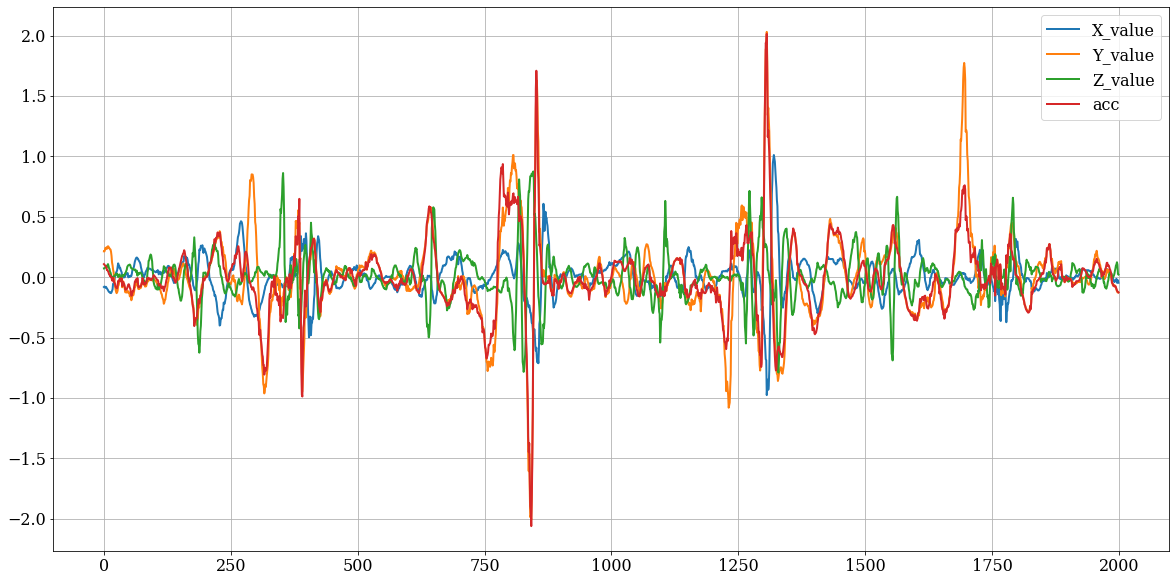

In [ ]:
_ = diff_ts.iloc[:2000, :].plot(figsize=(20, 10))
plt.grid(True)

### Проверка рядов на стационарность с помощью критерия KPSS и ADF теста

**Критерий KPSS**

In [ ]:
for col in explored_columns:
    stat, p_value, _, _ = kpss(diff_ts[col])
    print(f'Statistic = {round(stat, 3)}, p_value = {p_value}')

Statistic = 0.008, p_value = 0.1
Statistic = 0.011, p_value = 0.1
Statistic = 0.012, p_value = 0.1
Statistic = 0.011, p_value = 0.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value re

**Вывод:** На уровне значимости 5% предположение о стационарности дифф.временных рядов выполняется

**ADF тест**

In [ ]:
for col in explored_columns:
    result = adfuller(diff_ts[col])
    stat, p_value = result[:2]
    print(f'Statistic = {round(stat, 3)}, p_value = {p_value}')

Statistic = -20.222, p_value = 0.0
Statistic = -19.385, p_value = 0.0
Statistic = -22.27, p_value = 0.0
Statistic = -20.464, p_value = 0.0


**Вывод:** Нулевое значение p-value говорит о том, что выполняется альтернатива о стационарности временного ряда

### Исследование графиков ACF и PACF для выбора начального приближения p и q в ARIMA(p, d, q)

Автокорреляция

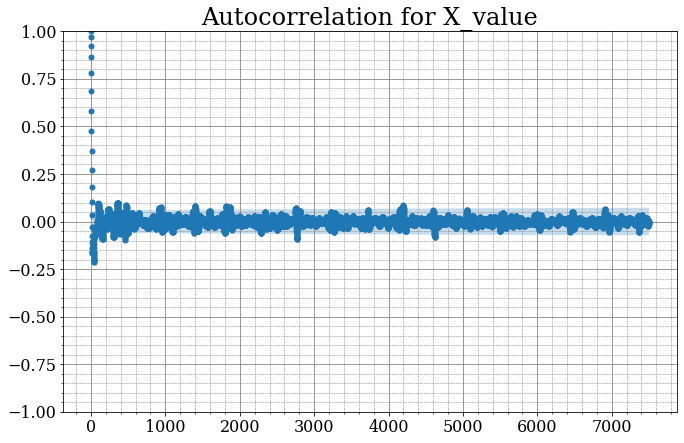

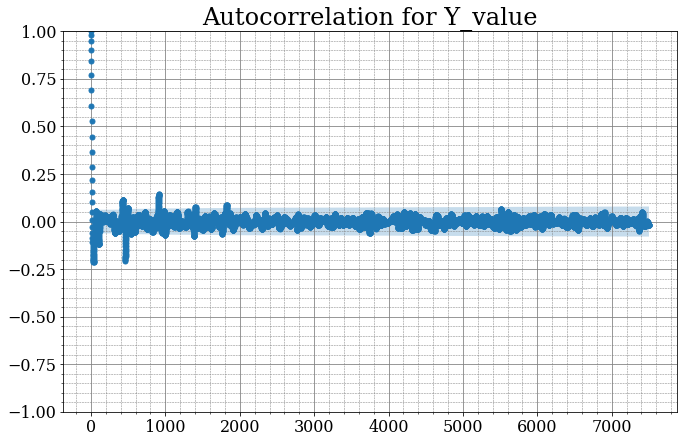

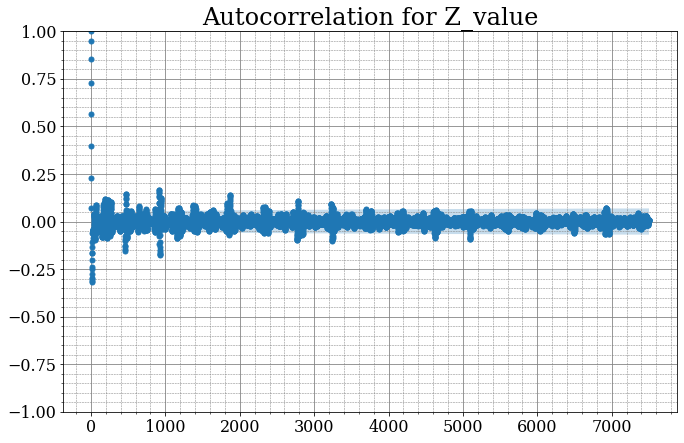

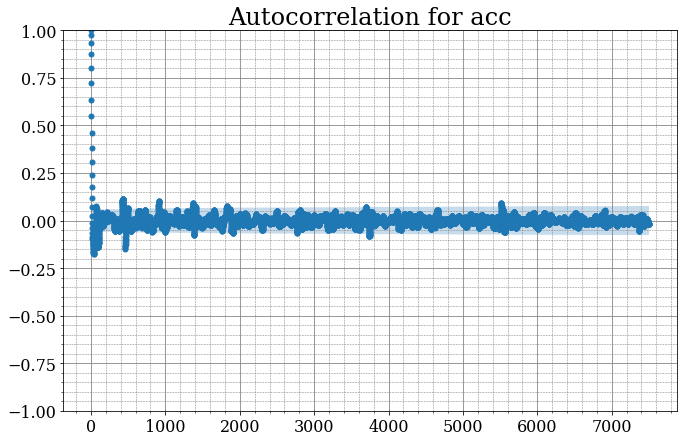

In [ ]:
for col in explored_columns:
    plot_acf(
        diff_ts[col],
        lags = int(len(ts)/2),
        use_vlines = False,
    ) 
    plt.tick_params(axis='both', which='major')
    plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', 
        color = 'gray', 
        linestyle = '--',
        linewidth = 0.5)
    plt.title(f'Autocorrelation for {col}')
    plt.show()

Автокорреляция на меньшем временном интервале

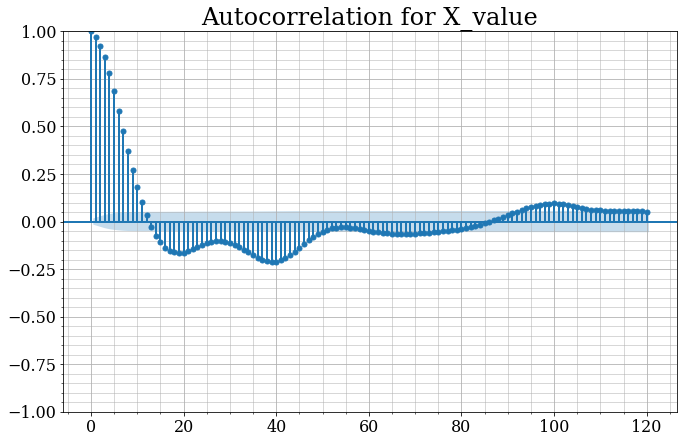

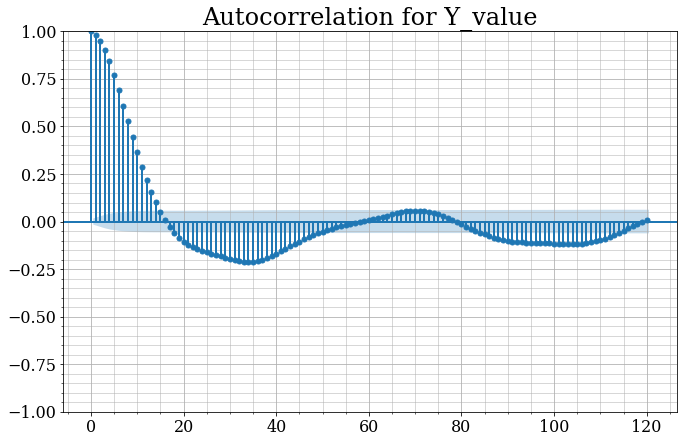

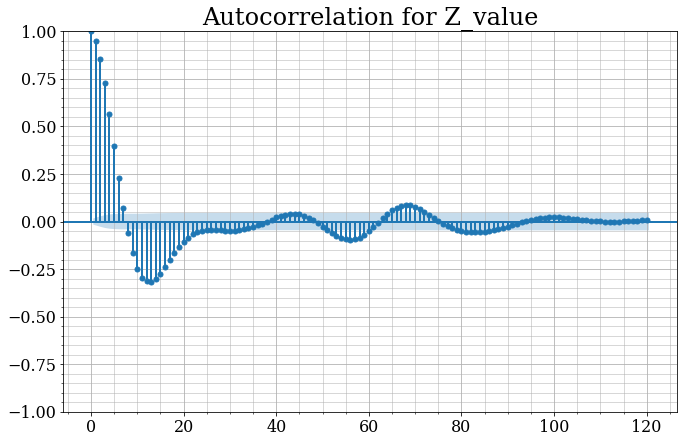

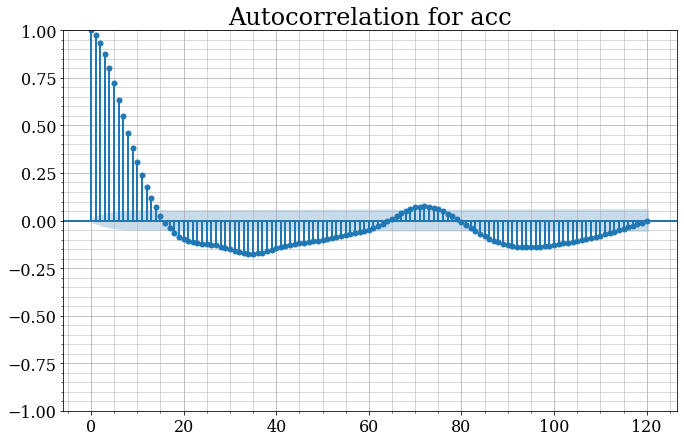

In [ ]:
for col in explored_columns:
    plot_acf(diff_ts[col], lags=120,
        title = f'Autocorrelation for {col}')
    plt.grid(which='major', linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', linewidth = 0.5)

Частичная автокорреляция

/home/eduard/anaconda3/envs/python/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/eduard/anaconda3/envs/python/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/eduard/anaconda3/envs/python/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warning

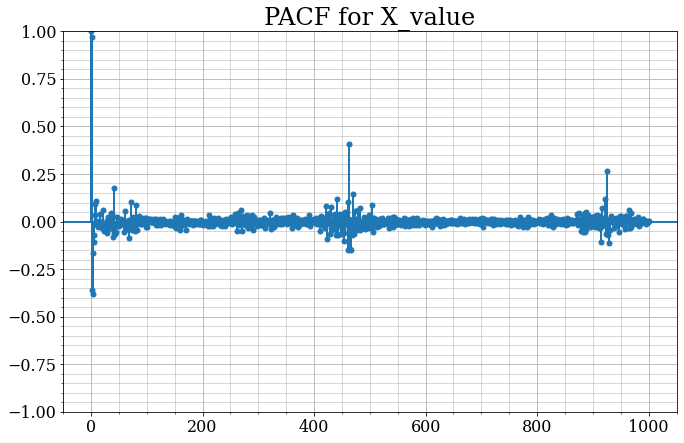

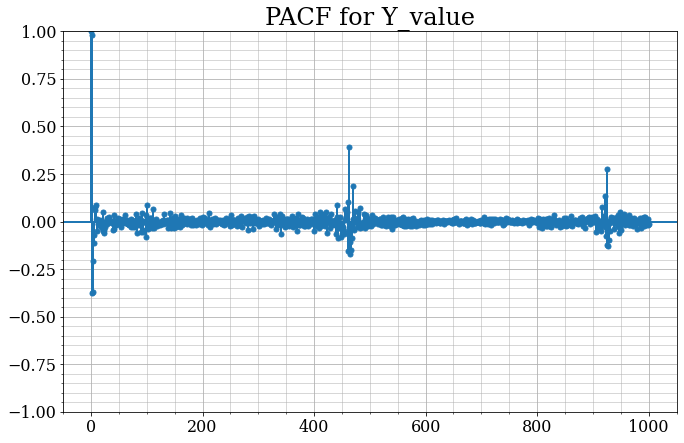

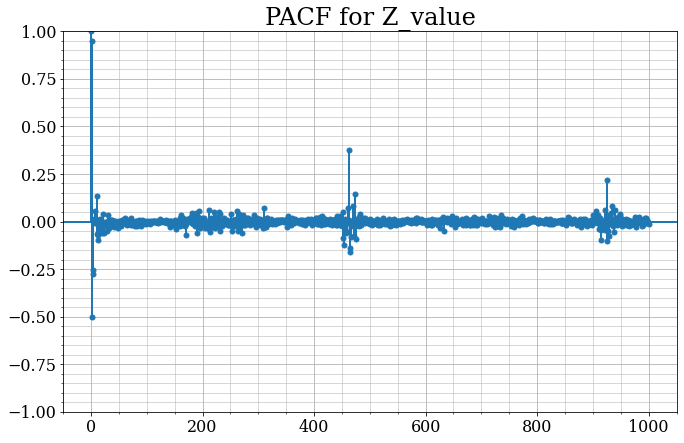

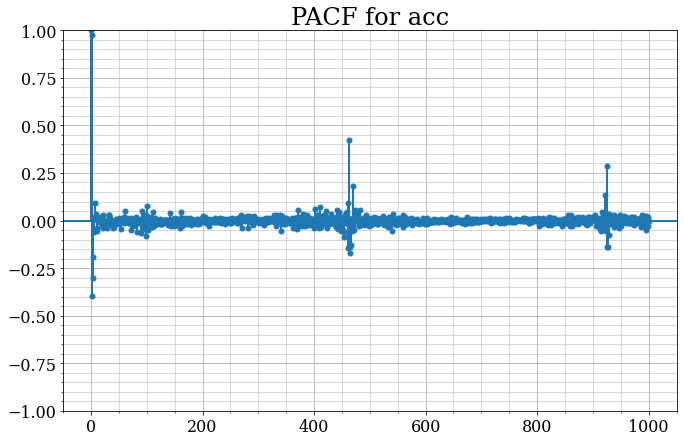

In [ ]:
for col in explored_columns:
    plot_pacf(diff_ts[col], lags=1000, title = f"PACF for {col}")
    plt.grid(which='major', linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', linewidth = 0.5)

Частичная автокорреляция на меньшем временном интервале

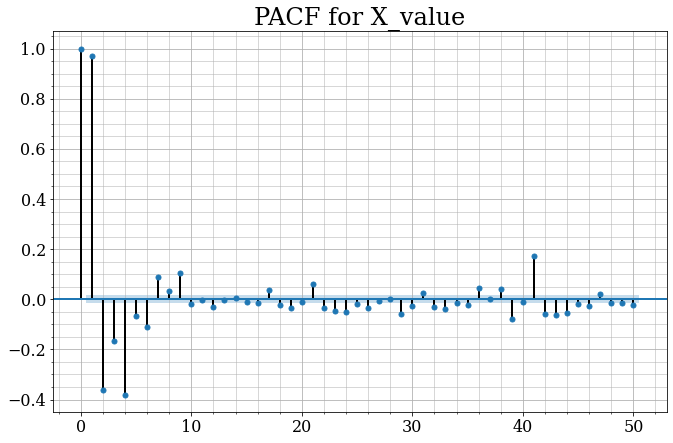

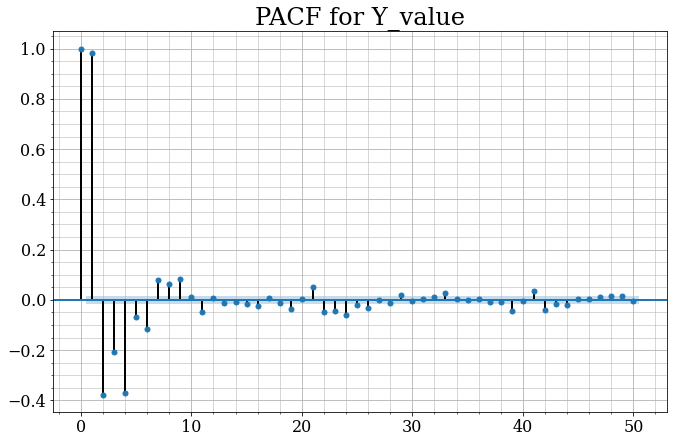

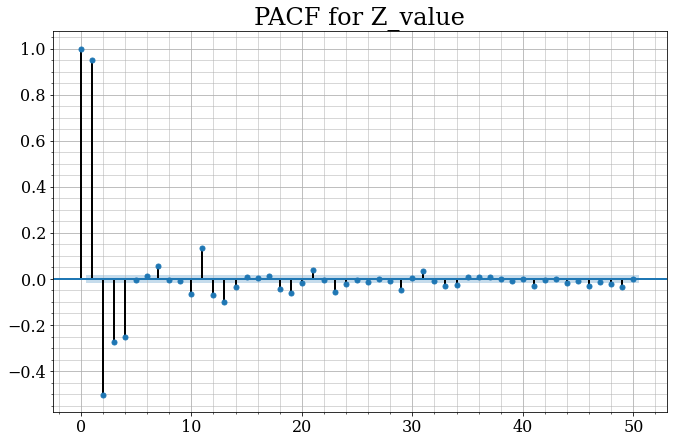

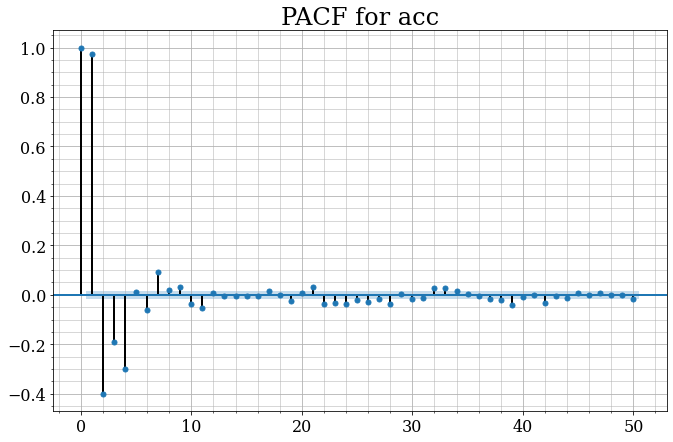

In [ ]:
for col in explored_columns:
    plot_pacf(diff_ts[col], lags=50, title = f"PACF for {col}")
    plt.grid(which='major', linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', linewidth = 0.5)

**Вывод:**  
1. Начальное приближение p --- последний значимый пик у PACF = 4 (не берём значение 462, поскольку тогда модель будет слишком долго обучаться)
2. Начальное приближение q --- последний значимый пик у ACF = 35

___
# Построение и выбор моделей <a name="pipline"></a>

 Определите вашу модель и выбранный вами подход к выбору параметров модели.
 
 Проиллюстрируйте, если это возможно.
  
 Можно также применить информационные критерии BIC, AIC, MallowCp.

Выбор модели осуществляется по сетке p и q, миниммизируя информационный критерий Шварца (BIC). Для экономии времени будем предсказывать только значение ускорения.

In [13]:
train_ts, test_ts = ts.iloc[:12000, :], ts.iloc[12000:15000, :]

tr_boxcox_ts = []

for i, col in enumerate(explored_columns):
    add_const = boxcox_add_constants[i]
    mult_const = boxcox_mult_constants[i]
    modified_ts = train_ts[col] * mult_const + add_const
    modified_ts = sps.boxcox(modified_ts, lmbda=LAMBDA)
    
    tr_boxcox_ts.append(modified_ts)
    
tr_boxcox_ts = pd.DataFrame(tr_boxcox_ts).T
tr_boxcox_ts.columns = explored_columns
tr_diff_ts = diff_dataframe(tr_boxcox_ts, PERIOD)

In [18]:
p_delta = 2
q_delta = 5
grid_size = 3
p0 = 4
q0 = 35
p_grid = np.linspace(p0-p_delta, p0+p_delta, grid_size)
q_grid = np.linspace(q0-q_delta, q0+q_delta, grid_size)

best_model = None
best_results = None
best_bic = float(np.inf)

for p in p_grid:
    for q in q_grid:
        model = ARIMA(endog=tr_diff_ts['acc'], order=(p, 0, q))
        results = model.fit()
        
        if results.bic < best_bic:
            best_bic = results.bic
            best_model = model
            best_results = results

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

AttributeError: ignored

In [66]:
print('Best p =', best_model.k_ar_params)
print("Best q =", best_model.k_ma_params)

Best p = 2
Best q = 30


___
# Итоговые результаты и выводы <a name="results"></a>

Продемонстрируйте работу вашей итоговой модели.

Оцените:
* наибольший возможный горизонт предсказания;
* переобучение модели;
* выбранные вами дополнительниые критерии качества;
* ...

In [58]:
start_predictions = best_results.predict(len(train_ts)-PERIOD, 
                                         len(ts)-PERIOD-1, dynamic=True)

for ind in start_predictions.index:
    if ind < len(train_ts):
        start_predictions[ind] += tr_boxcox_ts['acc'][ind]
    else:
        start_predictions[ind] += start_predictions[ind - PERIOD]

predictions = start_predictions - boxcox_add_constants[-1]
predictions /= boxcox_mult_constants[-1]
predictions = inv_boxcox(predictions, LAMBDA)

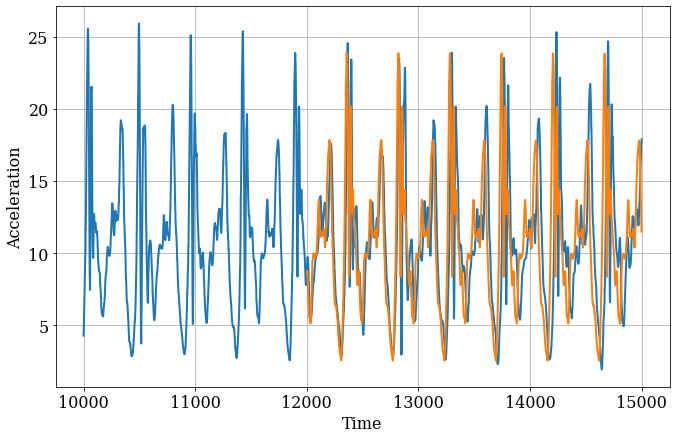

In [59]:
plt.plot(range(10000, len(ts)), ts.acc[10000:], label="Target value")
plt.plot(range(len(train_ts), len(ts)), predictions, label="Predicted")
plt.xlabel("Time", fontsize=16)
plt.ylabel("Acceleration", fontsize=16)
plt.grid(True)
plt.show()

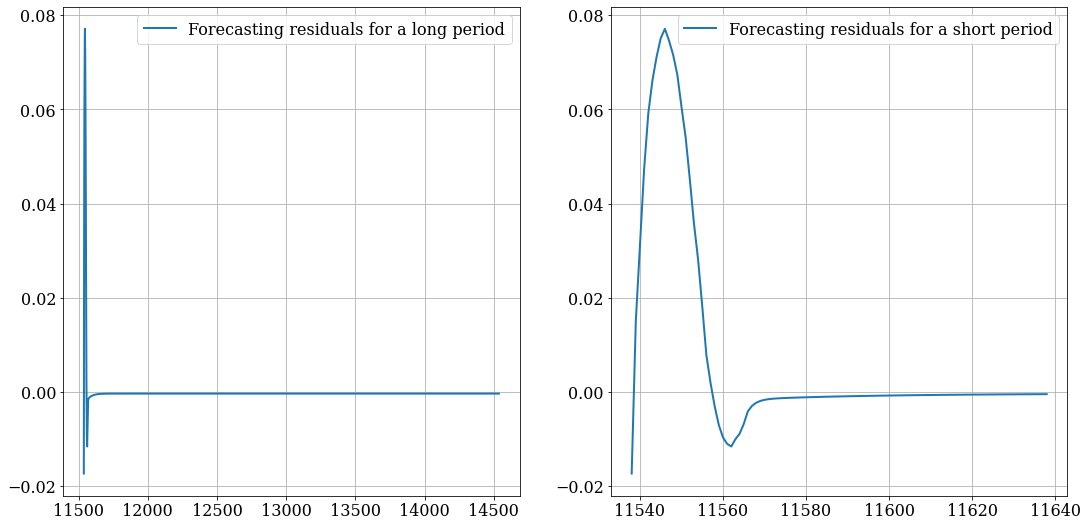

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].plot(best_results.predict(len(train_ts)-PERIOD, 
                                  len(ts)-PERIOD-1, dynamic=True), 
             label='Forecasting residuals for a long period')
axes[1].plot(best_results.predict(len(train_ts)-PERIOD, 
                                  len(train_ts)-PERIOD+100, dynamic=True),
             label='Forecasting residuals for a short period')

axes[0].legend()
axes[1].legend()
axes[0].grid(True)
axes[1].grid(True)
plt.show()

**Вывод:** Модели стационарных рядов (ARMA) дают только
краткосрочные “содержательные” прогнозы. Долгосрочные прогнозы не
являются информативными.  
Из графика выше видно, что при большом временном интервале значение прогноза равняется мат.ожиданию стац. ряда, что очень близко к нулю.  
Также стоит отметить, что оптимальный горизонт прогнозирования примерно равен q (в нашем случае он равен 30)

Выведем график ошибки модели

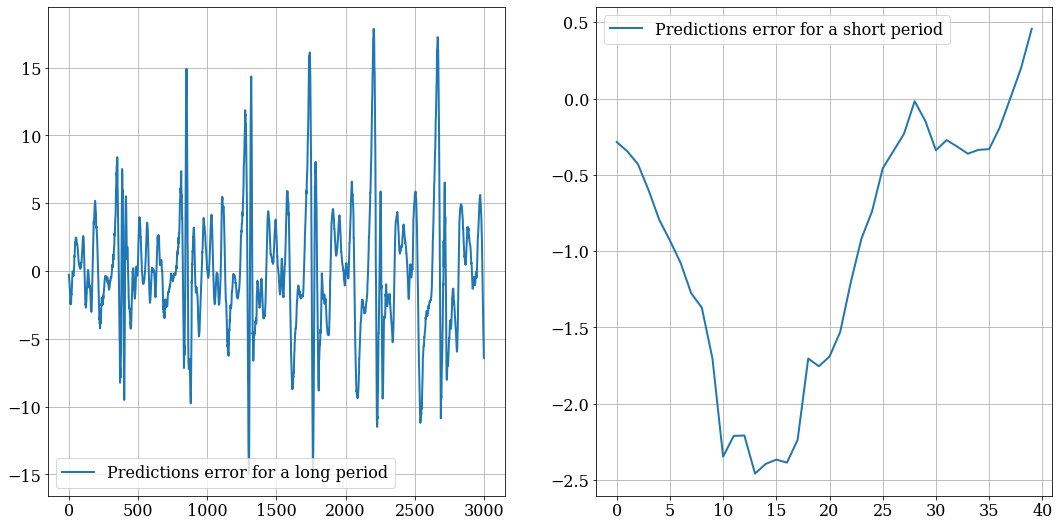

In [75]:
horizont = 40
errors = predictions.values - test_ts['acc'].values
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].plot(errors,
             label='Predictions error for a long period')
axes[1].plot(errors[:horizont],
             label='Predictions error for a short period')

axes[0].legend()
axes[1].legend()
axes[0].grid(True)
axes[1].grid(True)
plt.show()

Различные метрики качества модели

In [76]:
mse_horiz_err = np.mean(errors[:horizont]**2)
mae_horiz_err = np.mean(np.abs(errors[:horizont]))
mape_horiz_err = MAPE(test_ts['acc'].values[:horizont], 
                      predictions[:horizont])

print("MSE =", round(mse_horiz_err, 2))
print("MAE =", round(mae_horiz_err, 2))
print("MAPE =", round(mape_horiz_err, 2))

MSE = 1.71
MAE = 1.02
MAPE = 0.13
